# Import input files

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

PATH = '/content/drive/MyDrive/ColabResources/AudioProject' # make sure to adjust this based on your own file paths in google drive

Mounted at /content/drive
Note: using Google CoLab


# Setup imports and files

In [3]:
import sys, os
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy.stats
from matplotlib.ticker import MultipleLocator
import IPython.display as ipd
import numpy as np

# the following audio files can be downloaded off of the github containing this notebook
FOLDER_PATH = 'bach-fugue3-wtc1'
# AUDIO_PATH = 'OG-slow.wav'
AUDIO_PATH = '1.wav'
MODEL_PATH_1 = 'OG-fast.wav'
MODEL_PATH_2 = 'SCHIFF.wav'
# FOLDER_PATH = 'chopin-op10-no4'
# AUDIO_PATH = 'OG.wav'
# MODEL_PATH_1 = 'KISSIN.wav'
# MODEL_PATH_2 = 'LIU.wav'
# FOLDER_PATH = 'prokofiev-op75-no1'
# AUDIO_PATH = 'GAVRILOV.wav'
# MODEL_PATH_1 = 'KISSIN.wav'
# MODEL_PATH_2 = 'CHIU.wav'

AUDIO_FILE = os.path.join(PATH, FOLDER_PATH, AUDIO_PATH)
MODEL_FILE_1 = os.path.join(PATH, FOLDER_PATH, MODEL_PATH_1)
MODEL_FILE_2 = os.path.join(PATH, FOLDER_PATH, MODEL_PATH_2)

# where y = audio data and sr = sampling rate
y_0_duration = librosa.get_duration(path=AUDIO_FILE) # og
y_1_duration = librosa.get_duration(path=MODEL_FILE_1)
y_2_duration = librosa.get_duration(path=MODEL_FILE_2)
y, sr = librosa.load(AUDIO_FILE, duration=y_0_duration)

audio_list = []
tup = (y, sr,'OG')
audio_list.append((y,sr,'OG'))
x, fs = librosa.load(MODEL_FILE_1, duration=y_1_duration)
tup = ((x, fs, os.path.basename(MODEL_FILE_1)))
audio_list.append(tup)
x, fs = librosa.load(MODEL_FILE_2, duration=y_2_duration)
tup = ((x, fs, os.path.basename(MODEL_FILE_2)))
audio_list.append(tup)

OG_index = 0
MODEL_index = 2


# Dynamics Detection - MA Sones


## Setup

Install packages

In [4]:
# install the CosmoDoIt package
!pip install https://github.com/erc-cosmos/cosmodoit/archive/main.zip

     - 423.6 kB 21.9 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 102.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for cosmodoit: filename=cosmodoit-0.1.5-cp311-cp311-linux_x86_64.whl size=500265 sha256=da6f3f580eb8ff10df8ff0f3443715e4d2564685fa14ec474d9a50c9372e537b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sern69wc/wheels/21/4d/17/4fcef1298ac3680368d5b908fdbe1ac52c4a3391b6c7afa4fb
  Created wheel for lowess: filename=lowess-1.0.3-py3-none-any

Import libraries and load audio

In [5]:
OG_audio = audio_list[OG_index][0]
OG_fs = audio_list[OG_index][1]
MODEL_audio = audio_list[MODEL_index][0]
MODEL_fs = audio_list[MODEL_index][1]

The following methods are adapted from CosmoDoIt's `get_loudness.py` module, which has a few errors that make it unusuable without revision.

In [6]:
from typing import Iterable, List, Optional
import pandas as pd
from music_features import _ma_sone as MA
import lowess

def clip_negative(x_array: Iterable[float]) -> List[float]:
    """Set negative values to zero."""
    return [0 if x < 0 else x for x in x_array]

def compute_loudness(x=None, fs=22050, *, smooth_span=0.03, no_negative=True, **kwargs):
    """Compute the raw loudness and its post-processed versions."""
    time, raw_loudness = compute_raw_loudness(x=x, fs=fs)
    norm_loudness = rescale(raw_loudness)
    smooth_loudness = smooth(norm_loudness, smooth_span)
    min_separation = len(time) // time[-1]
    envelope_loudness = peak_envelope(norm_loudness, min_separation)

    # Remove values below zero
    if no_negative:
        smooth_loudness = clip_negative(smooth_loudness)
        envelope_loudness = clip_negative(envelope_loudness)

    df = pd.DataFrame({'Time': time,
                       'Loudness': raw_loudness,
                       'Loudness_norm': norm_loudness,
                       'Loudness_smooth': smooth_loudness,
                       'Loudness_envelope': envelope_loudness})
    return df

def plot_loudness(time, raw_loudness, norm_loudness, smooth_loudness, envelope_loudness, *, show=True):
    """Display a pyplot graph of the loudness."""
    fig, ax1 = plt.subplots()
    ax1.set_ylabel('Loudness (sone)', fontsize=14)
    ax1.set_xlabel('Time (s)', fontsize=14)

    p1 = ax1.plot(time, raw_loudness, linestyle='-', linewidth=0.8, color=(0, 0, 180/255))

    ax2 = ax1.twinx()

    p2 = ax2.plot(time, norm_loudness, linestyle='-.', linewidth=0.5, color=(1, 160/255, 0))
    p3 = ax2.plot(time, smooth_loudness, linestyle='-', linewidth=3.8, color=(139/255, 0, 0))
    p4 = ax2.plot(time, envelope_loudness, linestyle='--', linewidth=1.5, color=(0.5, 0.5, 0.5))

    ax2.set_ylabel('Normalized Loudness (sone)', fontsize=14)
    ax2.set_xlim((time[0], time[-1]))
    ax2.set_ylim((0, 1))
    ax2.legend(p1+p2+p3+p4, ('original', 'normalized', 'smoothed', 'envelope'))

    if show:
        plt.show()

def compute_raw_loudness(x=None, fs=22050):
    """Compute the raw loudness using the python port of the MA toolbox."""
    if x.ndim == 2: # Make audio mono if it's stereo
        x = np.mean(x, 1)

    _, tmp = MA.ma_sone(x, fs=fs)
    time, raw_loudness = tmp.T  # Unpack by column
    return time, raw_loudness

def rescale(data):
    """Scale data linearly between 0 and 1."""
    return np.interp(data, (data.min(), data.max()), (0, 1))

def smooth(data, span):
    """Use lowess regression to smooth loudness."""
    if 0 < span < 1:  # span is given as a ratio
        span = np.floor(len(data)*span)
        span += span % 2 - 1
    bandwidth = (span+2)/len(data)
    return lowess.lowess(pd.Series(range(len(data))), pd.Series(data), bandwidth=bandwidth, polynomialDegree=2)

def peak_envelope(data, min_separation):
    """Find the peak envelope of loudness."""
    peaks_idx, _ = scipy.signal.find_peaks(data, distance=min_separation+1)  # +1 for consistency with matlab
    peaks_y = data[peaks_idx]
    spline = scipy.interpolate.InterpolatedUnivariateSpline(peaks_idx, peaks_y)
    return spline(range(len(data)))

def find_nearest(array, value): # find nearest value in an array
    """
      Finds the closest float in an array to the given value parameter.

      Parameters:
          array (array-like): Array of floats.
          value (float): Target value to find in the array.

      Returns:
          idx (integer): Index of the closest number to the value parameter found in the array.
    """
    return (np.abs(array - value)).argmin()

def remove_silence(array, time_array, threshold=0.2):
    while(array[0] < threshold):
        array = np.delete(array, 0)
        time_array = np.delete(time_array, 0)
    while(array[-1] < threshold):
        array = np.delete(array, -1)
        time_array = np.delete(time_array, -1)
    return array, time_array

##Loudness analysis

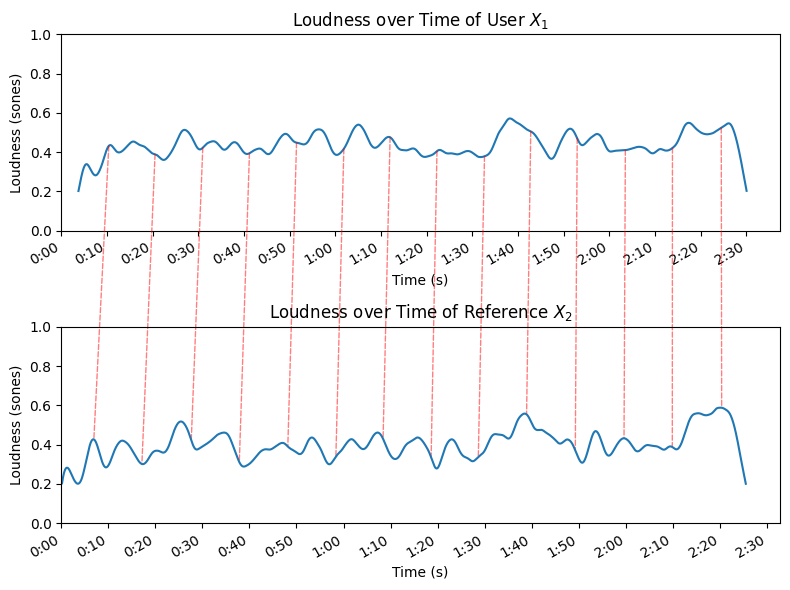

In [7]:
smooth_span = 0.06
OG_loud = compute_loudness(OG_audio, OG_fs, smooth_span=smooth_span)
MODEL_loud = compute_loudness(MODEL_audio, MODEL_fs, smooth_span=smooth_span)

OG_loud_smooth = OG_loud['Loudness_smooth'].to_numpy()
OG_times = OG_loud['Time'].to_numpy()
MODEL_times = MODEL_loud['Time'].to_numpy()
MODEL_loud_smooth = MODEL_loud['Loudness_smooth'].to_numpy()

OG_loud_smooth, OG_times = remove_silence(OG_loud_smooth, OG_times)
MODEL_loud_smooth, MODEL_times = remove_silence(MODEL_loud_smooth, MODEL_times)

fig, (ax1, ax2) = plt.subplots(2, sharex=False, figsize=(8,6))
ax1.plot(OG_times, OG_loud_smooth)
ax2.plot(MODEL_times, MODEL_loud_smooth)

for idx, ax in enumerate((ax1, ax2)):
  ax.set(xlabel='Time (s)')
  ax.set(ylabel='Loudness (sones)')
  if idx == 0:
    ax.set(title=f'Loudness over Time of User $X_{idx+1}$')
  else:
    ax.set(title=f'Loudness over Time of Reference $X_{idx+1}$')
  ax.yaxis.set_major_locator(MultipleLocator(0.2))
  ax.xaxis.set_major_locator(MultipleLocator(10))
  ax.xaxis.set_major_formatter(librosa.display.TimeFormatter(unit='m'))
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

#### Adjust y-axes to have identical limits ####
# Determine current y-limits for all axes
y_limits = [ax.get_ylim() for ax in (ax1, ax2)]

# Set identical y-limits for all axes
for ax in (ax1, ax2):
    ax.set_ylim(0, 1)
    ax.set_xlim(left=0)

# Plot the chromagrams for both files
hop_length = 1024

x_1_chroma = librosa.feature.chroma_cqt(y=OG_audio, sr=fs, hop_length=hop_length)
x_2_chroma = librosa.feature.chroma_cqt(y=MODEL_audio, sr=fs, hop_length=hop_length)

# Align chroma sequences
D, wp = librosa.sequence.dtw(X=x_1_chroma, Y=x_2_chroma, metric='cosine')
wp_s = librosa.frames_to_time(wp, sr=fs, hop_length=hop_length)

# Create a connection patch between the aligned time points in each subplot
from matplotlib.patches import ConnectionPatch

n_arrows = 15
for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
    index1 = find_nearest(OG_times, tp1)
    index2 = find_nearest(MODEL_times, tp2)
    if index1 == 0 or index2 == 0:
      continue
    if index1 == len(OG_times)-1 or index2 == len(MODEL_times)-1:
      continue

    con = ConnectionPatch(xyA=(tp1, OG_loud_smooth[index1]), xyB=(tp2, MODEL_loud_smooth[index2]),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='--',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)

plt.tight_layout()
plt.show()

## Derivative analysis

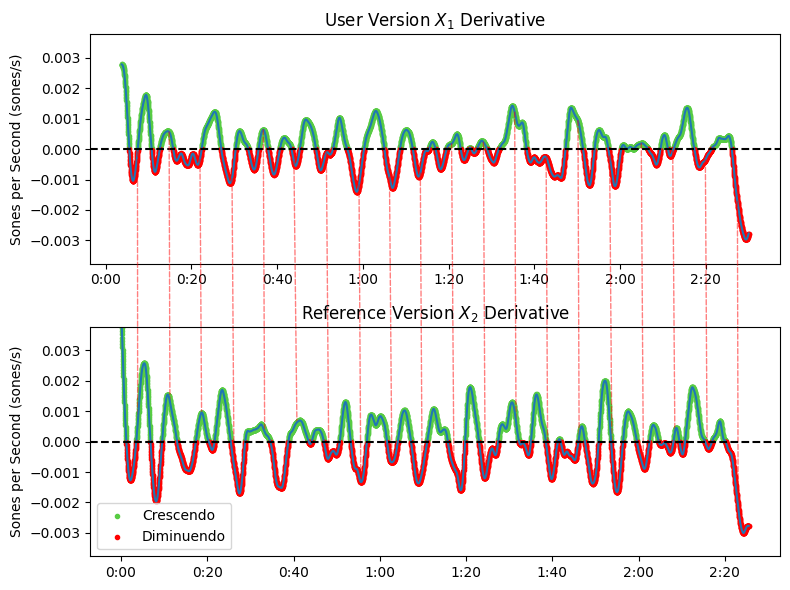

In [8]:
OG_loud_smooth_deriv = np.gradient(OG_loud_smooth)
MODEL_loud_smooth_deriv = np.gradient(MODEL_loud_smooth)

BOUND = max(np.abs(min(np.min(OG_loud_smooth_deriv), np.min(MODEL_loud_smooth_deriv))),
            np.abs(max(np.max(OG_loud_smooth_deriv), np.max(MODEL_loud_smooth_deriv))))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(8,6))

ax1.plot(OG_times, OG_loud_smooth_deriv)
ax1.set(title=f'User Version $X_{1}$ Derivative', ylabel = 'Sones per Second (sones/s)')
ax1.set(ylim=(BOUND * -1, BOUND))
ax1.axhline(y=0, color='black', linestyle='dashed')

pos = np.where(OG_loud_smooth_deriv > 0)
ax1.scatter(OG_times[pos], OG_loud_smooth_deriv[pos], color='#58cc43', label='Crescendo', marker='.')
neg = np.where(OG_loud_smooth_deriv < 0)
ax1.scatter(OG_times[neg], OG_loud_smooth_deriv[neg], color='red', label='Diminuendo', marker='.')

ax1.xaxis.set_major_formatter(librosa.display.TimeFormatter(unit='m'))
ax1.yaxis.set_major_locator(MultipleLocator(0.001))


ax2.plot(MODEL_times, MODEL_loud_smooth_deriv)
ax2.set(title=f'Reference Version $X_{2}$ Derivative', ylabel = 'Sones per Second (sones/s)')
ax2.set(ylim=(BOUND * -1, BOUND))
ax2.axhline(y=0, color='black', linestyle='dashed')

pos = np.where(MODEL_loud_smooth_deriv > 0)
ax2.scatter(MODEL_times[pos], MODEL_loud_smooth_deriv[pos], color='#58cc43', label='Crescendo', marker='.')
neg = np.where(MODEL_loud_smooth_deriv < 0)
ax2.scatter(MODEL_times[neg], MODEL_loud_smooth_deriv[neg], color='red', label='Diminuendo', marker='.')

ax2.xaxis.set_major_formatter(librosa.display.TimeFormatter(unit='m'))
ax2.yaxis.set_major_locator(MultipleLocator(0.001))

n_arrows = 21
for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]: # Create a connection patch between the aligned time points in each subplot
    index1 = find_nearest(OG_times, tp1)
    index2 = find_nearest(MODEL_times, tp2)
    if index1 == 0 or index2 == 0: # skip this iteration if either index is 0 to avoid out-of-graph connections
      continue
    if index1 == len(OG_times)-1 or index2 == len(MODEL_times)-1: # skip this iteration if either index is 0 to avoid out-of-graph connections
      continue

    con = ConnectionPatch(xyA=(tp1, OG_loud_smooth_deriv[index1]), xyB=(tp2, MODEL_loud_smooth_deriv[index2]),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='--',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)

plt.legend()
plt.tight_layout()
plt.show()